# Classifying Images as Birds or Airplanes


**Dataset:** https://www.cs.toronto.edu/~kriz/cifar.html<br>


More writeup stuff.
Must include learning objectives, explainations of similar work, how my work differs etc. 
probably do an abstract to explain this project as well.

## Import required libraries

PyTorch for building and training the neural network.

In [66]:
import torch

Torchvision

In [67]:
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset


Numpy for data manipulation and preprocessing

In [68]:
import matplotlib.pyplot as plt

In [69]:
import numpy as np

## Data Pre-processing

### Loading and transforming the data

First we can define a transform for the image data we are about to import, turning them into tensors. We do this so [INSERT REASON HERE]. This also has the benefit of automatically normalising us from a range from 0-255, which while not necessary for image data, is worth doing for advantages such as faster training.
[SOURCE: https://machinelearningmastery.com/how-to-manually-scale-image-pixel-data-for-deep-learning/].

In [70]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) #Take off 0.5 from each channel so mean is 0

Next we load the train and test dataset from the CIFAR-10, while also applying the transform:

In [71]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


Files already downloaded and verified


Now we can view the properties of the datasets we have imported:

In [72]:
print("Train-set size:", len(trainset))
print("Test-set size:", len(testset))
print("Classes: ", trainset.classes)

Train-set size: 50000
Test-set size: 10000
Classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


As the CIFAR-10 dataset has already sorted the dataset into training and testing automatically we do not need to worry about this. It has a test to train ratio of 5:1

### Filtering the data

As we can see, this dataset currently consists of 10 seperate classes, while we only want to classify between airplanes and birds. For this reason, we will filter out the other classes:

In [73]:
#0 and 2 correspond to the index of the 'airplane' and 'bird' classes
filtered_classes = [0, 2]

train_indices = [i for i, label in enumerate(trainset.targets) if label in filtered_classes]
test_indices = [i for i, label in enumerate(testset.targets) if label in filtered_classes]

#Convert label #2 -> #1 so we have labels 0 and 1 for binary image classification
for i in train_indices: trainset.targets[i] = 1 if trainset.targets[i] == 2 else trainset.targets[i]
for i in test_indices: testset.targets[i] = 1 if testset.targets[i] == 2 else testset.targets[i]

trainset_filtered = torch.utils.data.Subset(trainset, train_indices)
testset_filtered = torch.utils.data.Subset(testset, test_indices)

Upon filtering the dataset, we can view the properties of the new subset below. Notice how the train and test sets have shrunk to 20% of the original size, as we have removed the 80% we are not using.

In [74]:
print("Train-set size:", len(trainset_filtered))
print("Test-set size:", len(testset_filtered))
print([trainset.classes[i] for i in filtered_classes])


Train-set size: 10000
Test-set size: 2000
['airplane', 'bird']


### Viewing the data

Next we can observe the images and labels in this dataset to ensure that it is working as expected.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Bird label:  1


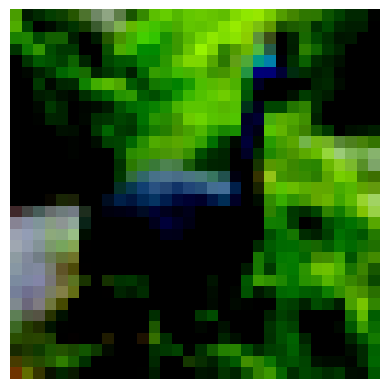

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Plane label:  0


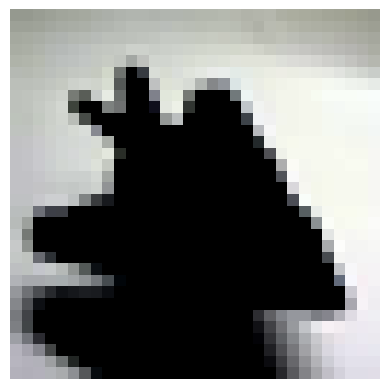

In [75]:
#1st bird in the data set
bird_image, bird_label = trainset_filtered[0]
print("Bird label: ", bird_label)
plt.imshow(bird_image.permute(1,2,0))
plt.axis('off')
plt.show()

#1st plane in the dataset
plane_image, plane_label = trainset_filtered[4]
print("Plane label: ", plane_label)
plt.imshow(plane_image.permute(1,2,0))
plt.axis('off')
plt.show()

As this is a binary image classification task, I will change the bird label from 2 -> 1 so the labels can be recognised as binary by the future Binary Cross Entropy loss function we are using later. If you are doing a binary image classification task, the labels will be required to match 0 and 1. Otherwise you can stick with their default values.

As we can see label 2 is linked with the bird label, and label 0 is linked with the planes image, as expected.

### Creating dataloaders

Next we must create dataloaders, so we can have an iterable over our dataset:

In [76]:
trainloader = torch.utils.data.DataLoader(trainset_filtered, batch_size=4, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(testset_filtered, batch_size=4, shuffle=False, num_workers=4)

We should also have class labels for our invididual classes to be distinguished. In this case, it is 'bird' and 'airplane' which can be configured as follows:

In [77]:
classes = {'bird', 'airplane'}

We shuffle the data in our training dataset. This is to make sure that the model doesn't learn anything from the order of images input. This isn't necessary with our testing dataset however, so we can leave this false. 
Num_workers relates to the number seperate workers that will load the data in parallel. While a high number of workers may speed up performance, it may also increase memory utilisation so its good to strike a balance.
We are also using a batch size of 4. A larger batch size can be good for speed, but too high and we risk lower accuracy and overfitting.

## Defining the Model

In [78]:
for i, (x_train, y_train) in enumerate(trainset_filtered):
    break

In [79]:
x_train.shape

torch.Size([3, 32, 32])

Testing neural net stuff

In [80]:
conv1 = nn.Conv2d(3,6,4,1)

In [81]:
x = x_train.view(1,3,32,32)
x.shape

torch.Size([1, 3, 32, 32])

In [82]:
x = F.relu(conv1(x))

In [83]:
x.shape

torch.Size([1, 6, 29, 29])

In [84]:
x = F.max_pool2d(x, 2, 2)

In [85]:
x.shape

torch.Size([1, 6, 14, 14])

In [86]:
conv2 = nn.Conv2d(6,16,4,1)

In [87]:
x = F.relu(conv2(x))

In [88]:
x.shape

torch.Size([1, 16, 11, 11])

In [89]:
x = F.max_pool2d(x, 2, 2)
x.shape

torch.Size([1, 16, 5, 5])

Next we must define a model, which we are doing with a Convolutional Neural Network as these are very good for classifying images.

A convolution neural network has many different layers. These include, convolutional, pooling and fully connected layers that take the following parameters:
Convolutional(
    Input
    Output
    Kernel Size
    Stride
    )
Pooling(
    X
    Y
    Z)
Fully Connected Layer(
    Kernel Size
    Stride
)

Rather than redefining our pooling layer, as we want one of the same size so we can just call it twice

Output size of convolution = [(width/height of image) - (size of kernel)] / (stride) + 1. E.g., 32-5/1 + 1 = 27+1 = 28.

In [142]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3,6,5,1)
        self.pool = nn.MaxPool2d(2,2)
        
        self.fc1 = nn.Linear(14 * 14 * 6, 120)
        self.fc2 = nn.Linear(120,2)
    
    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = self.pool(x)
        x = x.view(-1, 14*14*6)  # Flatten the tensor before feeding it into fc1
        x = nn.functional.relu(self.fc1(x))  # Apply relu to the output of fc1
        x = self.fc2(x)  # Feeding to cross entropy loss so no need for relu activation function
        return x

simpleCNN = SimpleCNN()
simpleCNN

SimpleCNN(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1176, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=2, bias=True)
)

In [90]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # First convolutional layer takes 3 input channels (for RGB images), produces 16 output channels, and uses a 5x5 kernel for convolution.
        # Since each image is 32x32 pixels with 3 channels for RGB, applying 5x5 kernel with 1 stride = 28x28 output, so 16 channels with 28x28 output each.
        self.conv1 = nn.Conv2d(3,16,5,1)
        # Max Pooling layer with a 2x2 kernel and a stride of 2. This will reduce the spatial dimensions of the output from the first convolutional layer by half.
        # Turning 28x28 into 16 output channels of 14x14.
        self.pool = nn.MaxPool2d(2, 2)
        # Second convolutional layer takes the 16 channels of 14x14 produced by the first convolutional layer and pooling layer, produces 32 output channels, and uses a 5x5 kernel.
        # 14-5/1 + 1= 10, so another 5x5 kernel applied to the 16 channels of 14x14 produces 32 channels of 10x10.
        self.conv2 = nn.Conv2d(16,32,5,1)
        # 2 convolutional layers and a max pooling layer have reduced the dimensions of the input images from 3 channels of 32x32 to 32 channels of 10x10
        # Fully connected layers
        self.fc1 = nn.Linear(32 * 10 * 10, 120) # 32*10*10 = 3200 = size of flattened input data.
        self.fc2 = nn.Linear(120, 84) # Second fully connected layer takes 120 inputs from previous layer and produces 84 outputs.
        self.fc3 = nn.Linear(84,1) # 1 output, for binary classification (Bird or Airplane).

    #Conduct forward pass on model    
    def forward(self, x):
        #print("x size:", x.size())
        x = nn.functional.relu(self.conv1(x))
        #print("x size:", x.size())
        x = self.pool(x)
        #print("x size:", x.size())
        x = nn.functional.relu(self.conv2(x))
        #print("x size:", x.size())
        x = x.view(-1, 32*10*10) # Total number of elements in tensor
        #print("x size after resize:", x.size())
        x = nn.functional.relu(self.fc1(x))
        #print("x size:", x.size())
        x = nn.functional.relu(self.fc2(x))
        #print("x size:", x.size())
        x = torch.sigmoid(self.fc3(x)) # Apply sigmoid activation to the output layer for binary classification
        #print("x size:", x.size())
        x = torch.squeeze(x) #Squeezes the torch to our desired output size
        #print("x final size:", x.size())
        return x



model = Model()
model



Model(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=3200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

For our first convolution layer, we have an input of 3, as each image has 3 seperate inputs for different RGB channels

## Defining Model Hyperparameters

Explaination about hyperparameters

The loss function is what we use to calculate the error, quantifying the difference between the predicted output and the actual output. It helps us measure the performance of a model, while also indicating the direction to improve in.
For general image classification, you will likely want to use Cross-Entropy classification, however in our case as we only have 2 sets of images, we can use Binary Cross-Entropy as follows:

In [129]:
#loss_fn = nn.BCELoss()
loss_fn = nn.CrossEntropyLoss()

Next we must define an optimiser for our model. The role of an optimiser is to find the optimal model parameters. We will initialise it with a learning rate of 0.01 fairly standard learning rate of 0.01. If the learning rate is too high it can overshoot the solution, whereas if it is too low it can take too long to train, while also getting stuck in a local minimum. We will be using the ADAM optimiser, which naturally adjusts the learning rate to efficiently navigate the landscape during training, leading to faster convergence and improved network performance. [Source: https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/#:~:text=An%20optimizer%20is%20a%20function,overall%20loss%20and%20improving%20accuracy.]. There are many different available optimisers though, so you can choose whatever serves your purpose better.

In [112]:
#optimizer = optim.Adam(model.parameters(), lr = 0.001)
optimizer = optim.SGD(simpleCNN.parameters(), lr = 0.001, momentum = 0.9)

## Training the Model

We now have our basic model, and must train it. When training our dataset we must consider how many 'epochs' we want. An epoch in machine learning is definied as one complete pass of the training dataset, and in very large datasets you may be able to use 1 epoch (or even less) resulting in 1 loop over the data. As we use more epochs while training, our training data should get closer to the expected output, however using too many epochs can cause overfitting. This is where the model learns the training data too well, and can perform well on this data but poorly on new, unseen data. To start, we will initialise a relatively low amount of epochs, at 5. This can be adjusted later based on how our model performs.

In [93]:
num_epochs = 5

First we will define the code for looping over our dataset and calculating the loss value:     

In [143]:
#For simple model
def train_one_epoch2(epoch):
    running_loss = 0.0
    # Loop over the dataset
    for i, (inputs, labels) in enumerate(trainloader, 0):
        
        optimizer.zero_grad()  # Zero the gradients

        #print(labels)
        outputs = simpleCNN(inputs)  # Get predicted values from training set (forwards pass)
        #print(outputs.data)
        loss = loss_fn(outputs, labels)  # Compute the loss between predicted values, and actual values (labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()  # Accumulate loss
        
        # Optionally, print the running loss every 250 mini-batches to monitor training progress.
        if i % 250 == 249:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}], Loss: {running_loss / 250:.4f}')
            running_loss = 0.0

In [94]:
def train_one_epoch(epoch):
    running_loss = 0.0
    # Loop over the dataset
    for i, (inputs, labels) in enumerate(trainloader, 0):
        
        optimizer.zero_grad()  # Zero the gradients

        labels = labels.float() #Makes labels float  for BCELoss
        #print(labels)
        outputs = model(inputs)  # Get predicted values from training set (forwards pass)
        #print(outputs.data)
        loss = loss_fn(outputs, labels)  # Compute the loss between predicted values, and actual values (labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()  # Accumulate loss
        
        # Optionally, print the running loss every 250 mini-batches to monitor training progress.
        if i % 250 == 249:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}], Loss: {running_loss / 250:.4f}')
            running_loss = 0.0


In [144]:
for epoch in range(num_epochs):
    train_one_epoch2(epoch = epoch)

Epoch [1/5], Step [250], Loss: 0.6936
Epoch [1/5], Step [500], Loss: 0.6916
Epoch [1/5], Step [750], Loss: 0.6906
Epoch [1/5], Step [1000], Loss: 0.6922
Epoch [1/5], Step [1250], Loss: 0.6926
Epoch [1/5], Step [1500], Loss: 0.6919
Epoch [1/5], Step [1750], Loss: 0.6904
Epoch [1/5], Step [2000], Loss: 0.6925
Epoch [1/5], Step [2250], Loss: 0.6916
Epoch [1/5], Step [2500], Loss: 0.6929
Epoch [2/5], Step [250], Loss: 0.6921
Epoch [2/5], Step [500], Loss: 0.6921
Epoch [2/5], Step [750], Loss: 0.6931
Epoch [2/5], Step [1000], Loss: 0.6917
Epoch [2/5], Step [1250], Loss: 0.6919
Epoch [2/5], Step [1500], Loss: 0.6906
Epoch [2/5], Step [1750], Loss: 0.6911
Epoch [2/5], Step [2000], Loss: 0.6920
Epoch [2/5], Step [2250], Loss: 0.6929
Epoch [2/5], Step [2500], Loss: 0.6924
Epoch [3/5], Step [250], Loss: 0.6931
Epoch [3/5], Step [500], Loss: 0.6934
Epoch [3/5], Step [750], Loss: 0.6917
Epoch [3/5], Step [1000], Loss: 0.6922
Epoch [3/5], Step [1250], Loss: 0.6914
Epoch [3/5], Step [1500], Loss: 0.

Simple accuracy

In [173]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        (inputs, outputs) = data
        outputs = simpleCNN(inputs) 
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
print(f"Accuracy: {100*correct/total}%")    

Accuracy: 65.5%


Accuracy of bigger model

In [183]:
loss_fn = nn.BCELoss()
total_loss = 0.0
total_correct = 0
total_samples = 0

for data in testloader:
    (inputs, labels) = data 
    labels = labels.float()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    total_loss += loss.item()
    predicted = outputs >= 0.5
    correct = (predicted.float() == labels).sum().item()
    total_correct += correct
    total_samples += labels.size(0)


average_loss = total_loss / len(testloader)
accuracy = total_correct / total_samples
print(f"Average loss: {average_loss}")
print(f"Accuracy: {accuracy}")

Average loss: 0.36803824863774937
Accuracy: 0.862


Testing data

In [170]:
#with torch.no_grad():
 #   for i, (inputs, labels) in enumerate(testloader, 0):
  #      outputs = model(inputs) 
   #     print(outputs.data)

correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
        (inputs, labels) = data
        outputs = simpleCNN(inputs) 
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted==labels).sum().item()
        print("EXPECTED:", labels, "OUTPUT:", outputs)
        print("PREDICTED:",predicted)

print(f"Accuracy: {100*correct/total}%")

EXPECTED: tensor([0, 0, 1, 1]) OUTPUT: tensor([[ 0.0359, -0.0093],
        [ 0.0215, -0.0053],
        [ 0.0486, -0.0151],
        [ 0.0336,  0.0132]])
PREDICTED: tensor([0, 0, 0, 0])
EXPECTED: tensor([0, 0, 1, 0]) OUTPUT: tensor([[ 0.0660,  0.0133],
        [ 0.0487, -0.0004],
        [ 0.0160, -0.0367],
        [ 0.0420, -0.0198]])
PREDICTED: tensor([0, 0, 0, 0])
EXPECTED: tensor([0, 0, 1, 1]) OUTPUT: tensor([[ 0.0012,  0.0523],
        [-0.0105, -0.0253],
        [ 0.0180, -0.0125],
        [ 0.0150, -0.0333]])
PREDICTED: tensor([1, 0, 0, 0])
EXPECTED: tensor([0, 0, 0, 1]) OUTPUT: tensor([[-0.0134, -0.0321],
        [ 0.0059, -0.0448],
        [-0.0424, -0.0043],
        [ 0.0026, -0.0005]])
PREDICTED: tensor([0, 0, 1, 0])
EXPECTED: tensor([0, 1, 0, 0]) OUTPUT: tensor([[ 0.0252, -0.0201],
        [ 0.0402, -0.0443],
        [ 0.0200, -0.0131],
        [ 0.0325, -0.0104]])
PREDICTED: tensor([0, 0, 0, 0])
EXPECTED: tensor([1, 1, 0, 1]) OUTPUT: tensor([[-0.0782,  0.0479],
        [ 0.0